In [1]:
import pandas as pd
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import tokenize, FreqDist, corpus, ngrams, RSLPStemmer, download
import seaborn as sns
from unidecode import unidecode

import pickle


In [6]:
def get_model_data(data, y_label):
    if data.empty:
        print("Os dados estão vazios.")
        return None,None
    
    x = data.drop(columns=[y_label])
    y = data[y_label]
    
    return x, y

def get_bag_of_words(data, max_features=50):
    """
    Gera a matriz bag-of-words a partir de uma lista de frases.

    Parâmetros:
    - data: lista de strings contendo as avaliações.
    - max_features: número máximo de palavras únicas a serem consideradas.

    Retorno:
    - Matriz esparsa como DataFrame.
    """

    # Garante que `data` seja uma lista de strings
    if isinstance(data, pd.Series):
        data = data.tolist()

    # Inicializa o vetorizador com o limite de max_features
    vetorizar = CountVectorizer(max_features=max_features)

    # Gera a matriz bag-of-words
    bag_of_words = vetorizar.fit_transform(data)
    print(bag_of_words.shape)

    # Converte a matriz esparsa para um DataFrame
    matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=vetorizar.get_feature_names_out())
    print(matriz_esparsa)

    return matriz_esparsa

def get_tfidf(data, max_features=50, ngram_range = (1, 2)):
    '''
    atribuir peso para as palvras
    '''
    # Garante que `data` seja uma lista de strings
    if isinstance(data, pd.Series):
        data = data.tolist()

    # Inicializa o vetorizador com o limite de max_features
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)

    # Gera a matriz bag-of-words
    matriz = tfidf.fit_transform(data)

    # Converte a matriz esparsa para um DataFrame
    matriz_esparsa = pd.DataFrame(matriz.todense(), columns=tfidf.get_feature_names_out())
    print(matriz_esparsa)

    return matriz_esparsa, tfidf

def generate_wordcloud(data, y):
    good_avaliations = data[y != 0]
    good_words = ' '.join([txt for txt in good_avaliations])

    good_cloud = WordCloud(width=800, height=500, max_font_size=100, collocations=False).generate(good_words)
    plt.figure(figsize=(10, 10))
    plt.title('Good Avaliations')
    plt.imshow(good_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    bad_avaliations = data[y == 0]
    bad_words =''.join([txt for txt in bad_avaliations])
    bad_cloud = WordCloud(width=800, height=500, max_font_size=100, collocations=False).generate(bad_words)
    plt.figure(figsize=(10, 10))
    plt.title('Bad Avaliations')
    plt.imshow(bad_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def data_treatment(data, token):
    '''
    LowerCase (lower())
    Remover Stopwords (corpus)
    Remover caracteres especiais (unidecode)
    Remover Pontuação e acentos (token e alpha)
    Simplificar a palavra para seu radical (stemmer)
    Utilizar paravras em contexto
    '''
    print('stopwords')
    stemmer = RSLPStemmer()

    irrelevant_words = corpus.stopwords.words('portuguese')
    irrelevant_words.extend([
        'filme','enquanto','mundo', 'algum', 'qualquer', 'pessoa', 'eu', 'acho','film','algum'
    ])
    stemmed_words = [stemmer.stem(unidecode(word)) for word in irrelevant_words]

    # Adicione as palavras processadas ao final da lista original
    irrelevant_words.extend(stemmed_words)

    frases_processadas = []

    for i, opiniao in enumerate(data):
        palavras_textos = token.tokenize(opiniao.lower())

        nova_frase = [stemmer.stem(unidecode(palavra)) for palavra in palavras_textos if palavra not in irrelevant_words and palavra.isalpha()]
        frases_processadas.append(' '.join(nova_frase))      

        if (i + 1) % 1000 == 0:  # Mostra progresso a cada 100 iterações
            print(f"Progresso: {i + 1}/{len(data)} opiniões processadas")

    return frases_processadas

def word_tokenization(data):
    token = tokenize.WordPunctTokenizer()
    
    data = data_treatment(data, token)
    all_words =''.join([txt for txt in data])
     
    print('tokenizando as palavras')
    token_words = token.tokenize(all_words)

    words_freq = FreqDist(token_words)
    df_freq = pd.DataFrame({'Palavra': list(words_freq.keys()), 'Frequencia': list(words_freq.values())})
    df_freq = df_freq.sort_values(by='Frequencia', ascending=False).reset_index(drop=True)
    print(df_freq)
    return df_freq,data, all_words

def plot_freq(df_freq, samples=20):
    """
    Plota as frequências das palavras como um gráfico de barras.
    
    Parâmetros:
    - df_freq: DataFrame contendo as palavras e suas frequências.
    - samples: Número de palavras a serem exibidas (por padrão, 20).
    """
    print('plotando words')
    # Garante que o DataFrame esteja ordenado
    df_freq = df_freq.sort_values(by='Frequencia', ascending=False)
    
    # Configura o tamanho da figura
    plt.figure(figsize=(10, 6))
    
    # Cria o gráfico de barras
    ax = sns.barplot(data=df_freq[:samples], x='Palavra', y='Frequencia', color='#ff0000')
    
    # Configura os rótulos e o título
    ax.set_ylabel('Contagem')
    ax.set_xlabel('Palavra')
    ax.set_title(f'Top {samples} Palavras Mais Frequentes')
    
    # Exibe o gráfico
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [3]:
data = pd.read_csv('data/imdb.csv')
print(data.head())

pt_data = data.drop(columns=['id', 'text_en'])

print(pt_data.head())

y_label = "sentiment"
x, y = get_model_data(pt_data, y_label)
print(x.head())
print(y.head())

#transform data
y = y.replace({'pos': 1, 'neg': 0})
print(y.head())
print(y.value_counts())


   id                                            text_en  \
0   1  Once again Mr. Costner has dragged out a movie...   
1   2  This is an example of why the majority of acti...   
2   3  First of all I hate those moronic rappers, who...   
3   4  Not even the Beatles could write songs everyon...   
4   5  Brass pictures movies is not a fitting word fo...   

                                             text_pt sentiment  
0  Mais uma vez, o Sr. Costner arrumou um filme p...       neg  
1  Este é um exemplo do motivo pelo qual a maiori...       neg  
2  Primeiro de tudo eu odeio esses raps imbecis, ...       neg  
3  Nem mesmo os Beatles puderam escrever músicas ...       neg  
4  Filmes de fotos de latão não é uma palavra apr...       neg  
                                             text_pt sentiment
0  Mais uma vez, o Sr. Costner arrumou um filme p...       neg
1  Este é um exemplo do motivo pelo qual a maiori...       neg
2  Primeiro de tudo eu odeio esses raps imbecis, ...       n

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16764\1583974502.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'pos': 1, 'neg': 0})


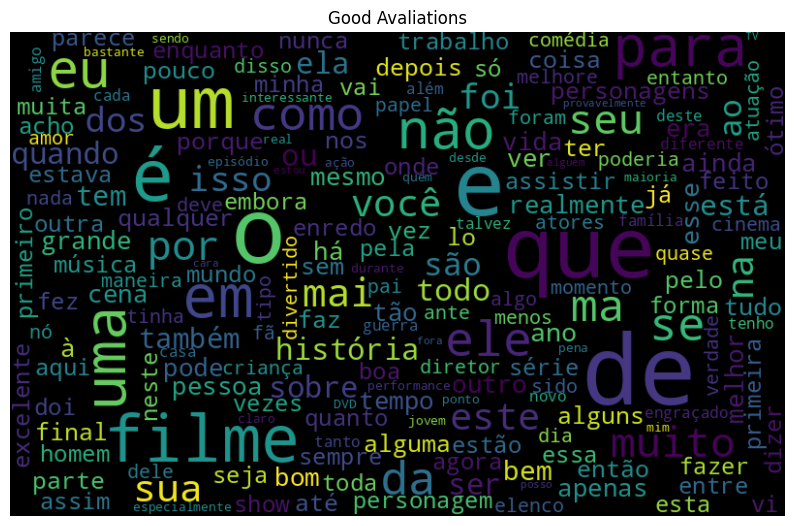

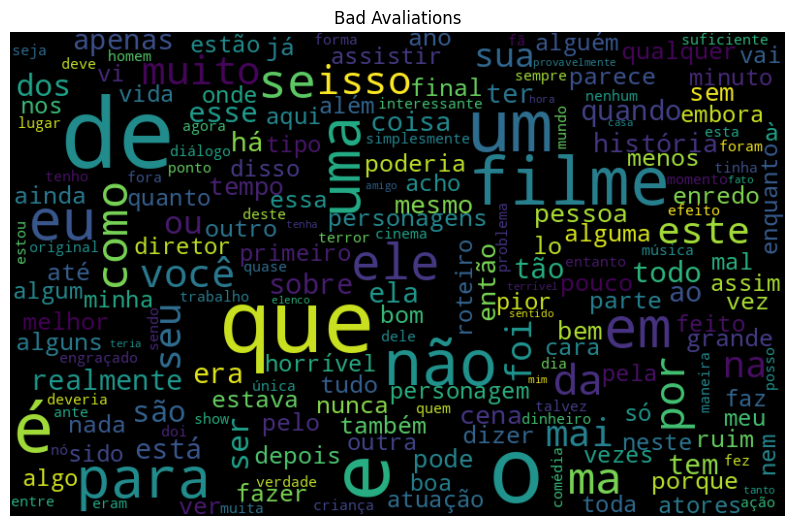

In [4]:
avaliacao = x['text_pt']
generate_wordcloud(avaliacao, y)

In [7]:

df_freq, data_words, all_words = word_tokenization(avaliacao)
print('palavras tokenizadas com sucesso')


stopwords
Progresso: 1000/49459 opiniões processadas
Progresso: 2000/49459 opiniões processadas
Progresso: 3000/49459 opiniões processadas
Progresso: 4000/49459 opiniões processadas
Progresso: 5000/49459 opiniões processadas
Progresso: 6000/49459 opiniões processadas
Progresso: 7000/49459 opiniões processadas
Progresso: 8000/49459 opiniões processadas
Progresso: 9000/49459 opiniões processadas
Progresso: 10000/49459 opiniões processadas
Progresso: 11000/49459 opiniões processadas
Progresso: 12000/49459 opiniões processadas
Progresso: 13000/49459 opiniões processadas
Progresso: 14000/49459 opiniões processadas
Progresso: 15000/49459 opiniões processadas
Progresso: 16000/49459 opiniões processadas
Progresso: 17000/49459 opiniões processadas
Progresso: 18000/49459 opiniões processadas
Progresso: 19000/49459 opiniões processadas
Progresso: 20000/49459 opiniões processadas
Progresso: 21000/49459 opiniões processadas
Progresso: 22000/49459 opiniões processadas
Progresso: 23000/49459 opiniões

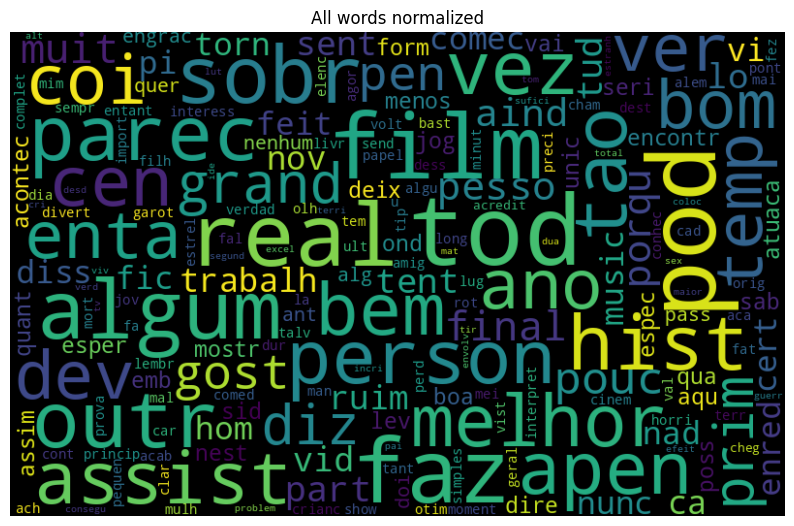

In [6]:
all_cloud = WordCloud(width=800, height=500, max_font_size=100, collocations=False).generate(all_words)
plt.figure(figsize=(10, 10))
plt.title('All words normalized')
plt.imshow(all_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

plotando words


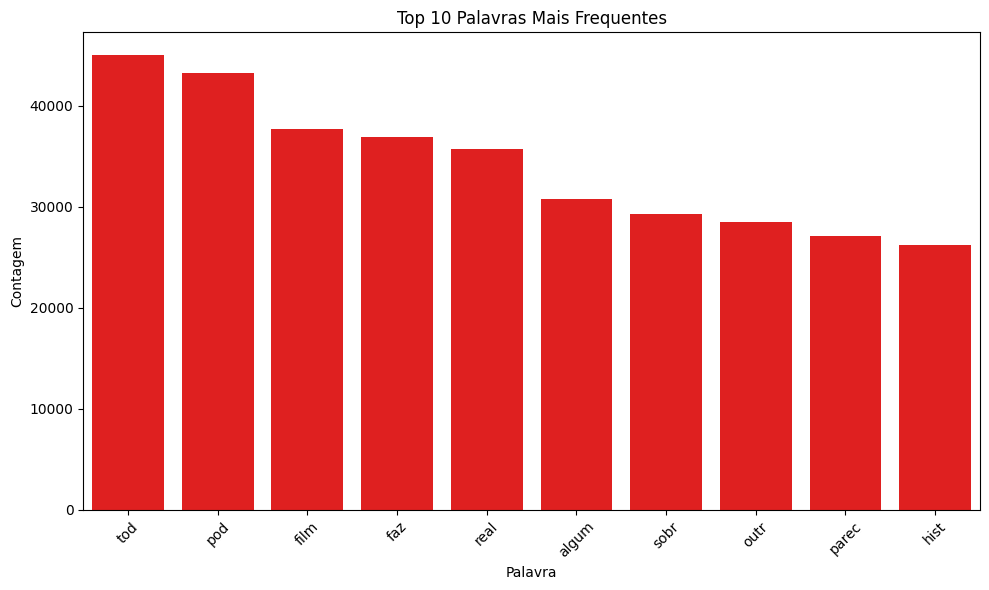

In [7]:
plot_freq(df_freq, 10)

In [8]:
max_features = 1000

ngram_range = (1, 2)
matriz, vetor_tfidf = get_tfidf(data_words, max_features, ngram_range)

          abert     abord  abr  absolut  absurd       aca  acab  aceit  \
0      0.000000  0.000000  0.0      0.0     0.0  0.000000   0.0    0.0   
1      0.000000  0.000000  0.0      0.0     0.0  0.169497   0.0    0.0   
2      0.000000  0.000000  0.0      0.0     0.0  0.000000   0.0    0.0   
3      0.000000  0.000000  0.0      0.0     0.0  0.084590   0.0    0.0   
4      0.000000  0.000000  0.0      0.0     0.0  0.086634   0.0    0.0   
...         ...       ...  ...      ...     ...       ...   ...    ...   
49454  0.000000  0.000000  0.0      0.0     0.0  0.000000   0.0    0.0   
49455  0.000000  0.309707  0.0      0.0     0.0  0.000000   0.0    0.0   
49456  0.000000  0.000000  0.0      0.0     0.0  0.000000   0.0    0.0   
49457  0.000000  0.000000  0.0      0.0     0.0  0.099165   0.0    0.0   
49458  0.145541  0.000000  0.0      0.0     0.0  0.000000   0.0    0.0   

            ach      acid  ...    visual  vit       viu      viv  volt  \
0      0.000000  0.000000  ...  0.000

In [9]:
#treinamento do modelo de regressão logística
random_seed = 18
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(matriz, y, random_state = random_seed, stratify=y, test_size=test_size)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(x_train, y_train)

#pesos
pesos = pd.DataFrame(
    regressao_logistica.coef_[0].T, 
    index = vetor_tfidf.get_feature_names_out()
)

# print(pesos.nlargest(50, 0))
# print(pesos.nsmallest(50, 0))


accuracy = regressao_logistica.score(x_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')



Accuracy: 86.28%


In [10]:


# Salvar o modelo no arquivo
nome_arquivo = "model/modelo_npl_imdb.pkl"
with open(nome_arquivo, 'wb') as arquivo:
    pickle.dump(regressao_logistica, arquivo)

print(f"Modelo salvo em: {nome_arquivo}")

# Salvar o vetor no arquivo
nome_arquivo = "model/vetor_npl_imdb.pkl"
with open(nome_arquivo, 'wb') as arquivo:
    pickle.dump(vetor_tfidf, arquivo)

print(f"Vetor salvo em: {nome_arquivo}")

# Salvar a acuracia no arquivo
nome_arquivo = "model/accuracy_imdb.pkl"
with open(nome_arquivo, 'wb') as arquivo:
    pickle.dump(accuracy, arquivo)

print(f"Acuracia salvo em: {nome_arquivo}")

# Salvar o dataframe de frequencia no arquivo
nome_arquivo = "model/df_freq_imdb.pkl"
with open(nome_arquivo, 'wb') as arquivo:
    pickle.dump(df_freq, arquivo)

print(f"Df_freq salvo em: {nome_arquivo}")

# Salvar all_words
nome_arquivo =  "model/all_words_imdb.pkl"
with open(nome_arquivo, 'wb') as arquivo:
    pickle.dump(all_words, arquivo)

print(f"all_words salvo em: {nome_arquivo}") 

Modelo salvo em: model/modelo_npl_imdb.pkl
Vetor salvo em: model/vetor_npl_imdb.pkl
Acuracia salvo em: model/accuracy_imdb.pkl
Df_freq salvo em: model/df_freq_imdb.pkl
all_words salvo em: model/all_words_imdb.pkl
